In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import pandas as pd
import numpy as np
from auto_segment_FEMPO import BasicSegmenterEG_FEMPO
#dreload(auto_feature)
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone
boston = load_boston()
#print(boston.data.shape)

In [3]:
base_address = "./Notebooks/Datasets/"
dataSets = []
dataSets_temp = []
data_names = ['servo','abalone','ozone']
for i in range(0,len(data_names)):
    dataSets_temp.append(pd.read_csv(base_address+data_names[i]+'.csv'))
    temp_data = pd.read_csv(base_address+data_names[i]+'.csv')
    temp_data = pd.get_dummies(temp_data)
    temp_output = pd.DataFrame(temp_data['output'])
    temp_data.drop('output',axis=1,inplace=True)
    temp_data = pd.concat([temp_data, temp_output], axis=1)
    dataSets.append(temp_data)
# Boston Data
b_feat = pd.DataFrame(boston.data)
b_feat.columns = ['feat_0','feat_1','feat_2','feat_3','feat_4','feat_5','feat_6','feat_7','feat_8','feat_9','feat_10','feat_11','feat_12']
b_target = pd.DataFrame(boston.target)
b_target.columns = ['output']
b_data = pd.concat([b_feat,b_target],axis=1)
dataSets.append(b_data)

In [4]:
def get_result(model_,data_, frac):
    model = clone(model_)
    output = data_['output']
    data_.drop('output',axis=1,inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(data_, output, test_size=frac)
    model.fit(X_train,y_train)
    test_result = model.predict(X_test)
    return mean_squared_error(y_test,test_result), test_result, model

In [5]:
def get_result_iter(data, N_iterations, frac, models):
    #get_result(FS,temp_data)
    model_list = []
    Result_mses = []
    temp_model_perf = []
    for i in range(0,len(models)):
        model_iter_results = []
        for j in range(0,N_iterations):
            temp_data = data.copy(deep=True)
            temp_rs, temp_pred, model = get_result(models[i],temp_data, frac)
            #print model.best_params_
            model_iter_results.append(temp_rs)
            model_list.append(model)
        temp_model_perf.append(model_iter_results)
        Result_mses.append(sum(model_iter_results)/len(model_iter_results))
    return Result_mses, model_list, temp_model_perf

In [6]:
Res_all_ds = []
model_f = []
perf_f = []
for i in range(0,len(dataSets)):
    t_data = dataSets[i].copy(deep=True)
    N_iterations = 1
    g_frac = 0.10
    # Parameters I want to sweep on.
    parameters = {
        'n_votes': [1,3,5,10],
        'init_sample_percentage':[0.2,0.5,1]
    }
    # Default params
    FEMPO = BasicSegmenterEG_FEMPO(**{'cxpb': 0.5,
 'indpb': 0.2,
 'init_sample_percentage': 0.5,
 'mutpb': 0.5,
 'n': 50,
 'n_population': 20,
 'ngen': 10,
 'statistics': False,
#  'test_size': 0.25,
 'tournsize': 3,
 'base_estimator': LinearRegression(),
 'n_votes' : 3
})
    
    #grid_model = RandomizedSearchCV(FS, parameters, verbose=True, scoring="mean_squared_error",n_iter=100)
#     grid_model = GridSearchCV(FEMPO, parameters, verbose=True, scoring="mean_squared_error", cv = 3, n_jobs= 1 )
    grid_model = FEMPO
    g_models = []
    g_models.append(grid_model)
#     g_models.append(Ba)
    g_models.append(BaggingRegressor(max_samples=0.99, bootstrap = True, oob_score = True, 
                                                  base_estimator = LinearRegression(),
                                                 n_estimators = 10))
    Result_t, model_list, model_perf = get_result_iter(t_data, N_iterations, g_frac, g_models)
    Res_all_ds.append(Result_t)
    model_f.append(model_list)
    perf_f.append(model_perf)
dataSet_names = ['Servo','Abalone','Ozone','Boston-housing']
model_names = ['FEMPO', 'BaggingRegressor']
Result_test_bench = pd.DataFrame(Res_all_ds)
Result_test_bench.columns = model_names
Result_test_bench.set_index([dataSet_names],inplace=True)
Result_test_bench

gen	nevals	avg	std	min	max
0  	20    	75 	0  	75 	75 
1  	13    	75.378	0.712402	74.7	77.28
2  	16    	75.404	1.05988 	73.04	77.34
3  	15    	75.986	1.34455 	73.56	79.12
4  	16    	75.724	1.54234 	72.46	79.42
5  	12    	75.647	0.82271 	73.78	77.18
6  	13    	75.637	1.10615 	73.56	77.68
7  	17    	76.437	1.48863 	73.84	80.36
8  	12    	76.558	0.890144	75.14	78.06
9  	14    	76.905	1.20113 	75.56	80.14
10 	19    	77.645	1.78594 	75.6 	81.64
gen	nevals	avg 	std	min 	max 
0  	20    	1880	0  	1880	1880
1  	16    	1889.12	23.184	1861.58	1968.22
2  	15    	1907.49	39.794	1861.58	2038.74
3  	14    	1912   	27.1722	1840.74	1951.66
4  	19    	1934.77	32.8397	1868.8 	1986.12
5  	13    	1947.34	31.812 	1876.1 	1992.08
6  	11    	1942.4 	39.3455	1876.1 	2048.48
7  	14    	1946.52	29.8158	1876.34	1990.74
8  	15    	1944.53	35.5794	1868.34	2046.84
9  	14    	1946.03	23.62  	1872   	1982.2 
10 	16    	1958.97	25.9711	1889.96	1994.14

C:\Python27\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Python27\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Python27\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Python27\lib\site-packages\sklearn


gen	nevals	avg	std	min	max
0  	20    	149	0  	149	149
1  	18    	150.021	2.49335	145.14	155.04
2  	15    	148.498	2.02602	144.4 	152.3 
3  	16    	149.329	2.59769	144.62	155.42
4  	10    	151.345	2.8866 	146.32	156.5 
5  	14    	152.656	3.38999	146.32	159.92
6  	11    	154.041	2.03354	150.86	158.08
7  	15    	154.222	2.34061	150.38	159.1 
8  	18    	154.781	2.99653	149.9 	158.96
9  	18    	157.55 	3.62799	149.46	162.16
10 	13    	159.114	3.8166 	149.32	166.2 

C:\Python27\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Python27\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Python27\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Python27\lib\site-packages\sklearn


gen	nevals	avg	std	min	max
0  	20    	228	0  	228	228
1  	16    	228.005	1.68472	221.58	231.02
2  	15    	228.569	1.60795	225.92	232.22
3  	15    	228.057	3.10267	221.6 	237.78
4  	15    	229.988	3.70008	225.42	240.38
5  	13    	228.29 	3.22455	222.74	239.92
6  	15    	228.586	3.45391	223.4 	239.84
7  	15    	231.198	5.1536 	223.78	240.84
8  	17    	237.515	6.48603	220.42	247.14
9  	17    	241.403	2.83964	235.54	247.7 
10 	15    	241.996	3.9251 	235.2 	253.34

C:\Python27\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Python27\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Python27\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Python27\lib\site-packages\sklearn

C:\Python27\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Python27\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Python27\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Python27\lib\site-packages\sklearn

,FEMPO,BaggingRegressor
Servo,1.592211,0.683436
Abalone,5.015324,6.132657
Ozone,21.601525,12.514801
Boston-housing,21.296510,21.614229


In [7]:
Result_test_bench

,FEMPO,BaggingRegressor
Servo,1.592211,0.683436
Abalone,5.015324,6.132657
Ozone,21.601525,12.514801
Boston-housing,21.296510,21.614229


In [28]:
for m in model_f:
    print m[0].best_params_
#     print m

{'n_votes': 10, 'init_sample_percentage': 0.5}
{'n_votes': 10, 'init_sample_percentage': 0.5}
{'n_votes': 10, 'init_sample_percentage': 0.5}
{'n_votes': 5, 'init_sample_percentage': 1}


[GridSearchCV(cv=3, error_score='raise',
        estimator=BasicSegmenterEG_FEMPO(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
             crossover_func=<function cxTwoPoint at 0x107C1DF0>, cxpb=0.5,
             indpb=0.2, init_sample_percentage=0.2, mutpb=0.5, n=10,
             n_population=20, n_votes=1, ngen=10, statistics=False,
             test_size=0.2, tournsize=3),
        fit_params={}, iid=True, loss_func=None, n_jobs=1,
        param_grid={'n_votes': [1, 3, 5, 10], 'init_sample_percentage': [0.2, 0.5, 1]},
        pre_dispatch='2*n_jobs', refit=True, score_func=None,
        scoring='mean_squared_error', verbose=True)]

In [21]:
p= pd.DataFrame(perf_f)

In [22]:
model_perf

[[20.725575714975999,
  18.634474713037562,
  25.123556530492966,
  25.217766426993695,
  13.882990718821937],
 [42.800736135077528,
  18.758960248776727,
  26.472713992396379,
  34.053993957266833,
  19.195811401078227]]

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  2.]),
 array([ 13.88299072,  15.01646829,  16.14994586,  17.28342343,
         18.416901  ,  19.55037857,  20.68385614,  21.81733371,
         22.95081129,  24.08428886,  25.21776643]),
 <a list of 10 Patch objects>)

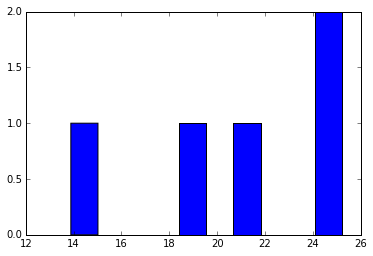

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(p.iloc[3][0])

(array([ 6.,  8.,  5.,  2.,  2.,  1.,  1.,  2.,  2.,  1.]),
 array([  5.15293162,   7.55897823,   9.96502485,  12.37107146,
         14.77711808,  17.18316469,  19.5892113 ,  21.99525792,
         24.40130453,  26.80735115,  29.21339776]),
 <a list of 10 Patch objects>)

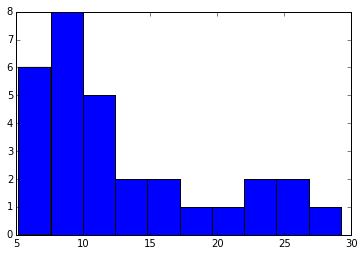

In [35]:
plt.hist(p.iloc[3][1])